# Universal atrial coordinates - Right atrium

## Import stuff

In [1]:
import os,sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pyvista as pv

sys.path.append('../openep-py')
import openep

sys.path.append('/mnt/d/vgmar/Documents/GitHub/USI/model-analyses/aux-functions')
import IgbHandling as igb
import quick_visualization as qv


%matplotlib qt

from openep.mesh.mesh_routines import (
    _create_trimesh,
    get_free_boundaries,
    calculate_mesh_volume,
    calculate_field_area,
    calculate_vertex_distance,
    calculate_vertex_path,
)

from openep.draw import draw_map,draw_free_boundaries

def freeBoundaryPoints(FF,tr):
    return  tr[FF[:,0],:]

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Load the original data in openEP format

To adjust to openEP, one can use the Matlab functions or try to create a "fake" case.

I created a fake RA case to use the native OpenEP functions, but it can just as easily be done by creating a case from scratch.

The following cells get the free boundaries of this geometry (veins must be open) and get corresponding mesh indices for them.

The user has to adjust the names of each boundary so that the correct indexes are selected

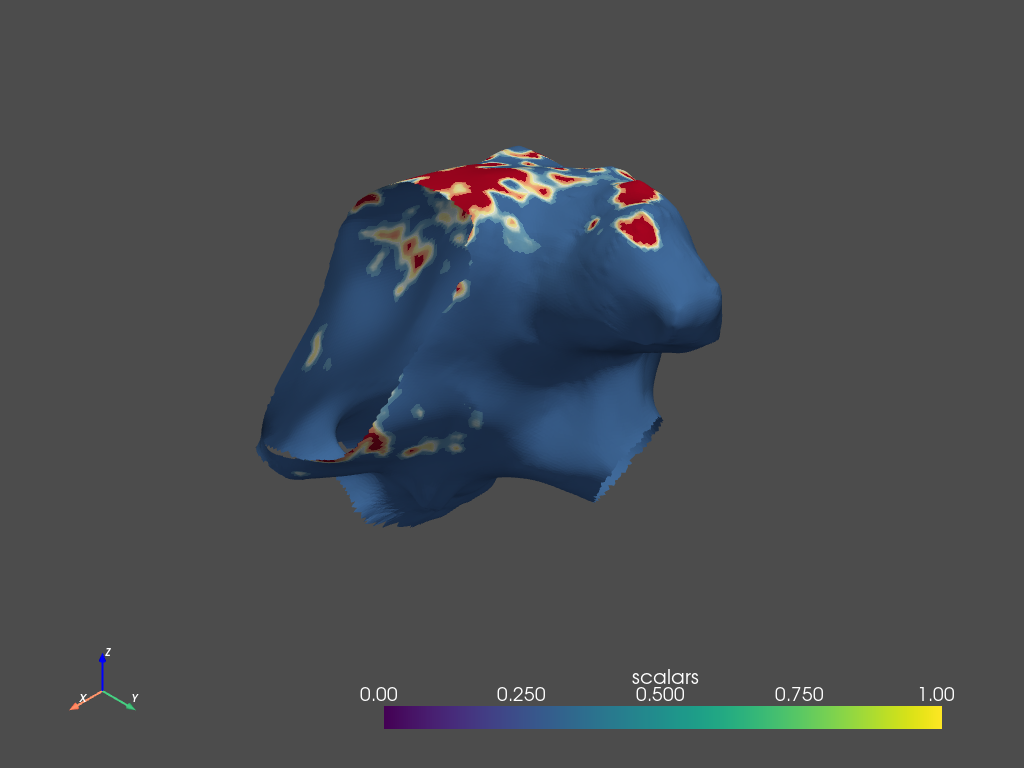

In [2]:
# Load file

# RA_number= 1
# filepath = '/mnt/d/vgmar/patient_data/Fibre_Files/RA_Endo/%d/'%RA_number
# expName = 'RA_'+str(RA_number)
# inFile = 'Labelled_%d_%d'%(RA_number,RA_number)

# filepath = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC_py/carp/'
# expName = 'Model_RA_endo'
# inFile = 'model24_raendo_mri_nocs.vtk'

filepath = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC_py/carp/ADAS03B_RA'
expName = 'ADAS03B_RA'
inFile = 'ADAS03B_RA.vtk'


############### Choose the method to import data

##### Load from .pts and .elem
# case = openep.load_opencarp(os.path.join(filepath,inFile+'.pts'),
#                             os.path.join(filepath,inFile+'.elem'),
#                             expName)
# mesh = case.create_mesh()

#### Load from vtk (Saved after the Paraview commands Clip > ExtractSurface > Triangulate > Save Data)
mesh = pv.PolyData(os.path.join(filepath,inFile))
# mesh.points = mesh.points*1e3 # mm to um


####
mesh.plot(jupyter_backend='static')


In [3]:
# Remove indices if no cells are present
removeInds = np.isin(np.arange(mesh.n_points),mesh.faces)

faces = mesh.faces.reshape(-1,4)[:,1:]
removeInds = ~np.isin(np.arange(mesh.n_points),faces.flatten())


mesh,ridx = mesh.remove_points(removeInds)
print(removeInds.sum())
# tmpmesh.plot(jupyter_backend='static')

0


In [4]:
# getAnatomicalStructures
FB = get_free_boundaries(mesh)
FF = FB.separate_boundaries()
FF_size = FB.n_points_per_boundary


tr = {}
for i in range(len(FF)):
    # % get the points of this boundary
    coords = freeBoundaryPoints(FF[i], mesh.points)
    
    # % find the centre of the points
    centre = np.mean(coords, axis=0)
    
    # % create a triRep of the boundary
    X = np.vstack([centre,coords])# [centre; coords];
    numpts = len(X)
    A = np.zeros(numpts-1,int)
    B = np.arange(1,numpts)
    C = np.hstack([np.arange(2,numpts),[2]])
    TRI = np.vstack([A,B,C]).T
    tr[i] = [TRI, X[:,0], X[:,1], X[:,2]]

In [5]:
# Get the actual indices for the free boundaries

for i,boundary in enumerate(FF):
    boundary = boundary[:,0]
    points = FB.points[boundary,:]

    boundaryPointIndices = [np.where((A==mesh.points[:,0])&(B==mesh.points[:,1])&(C==mesh.points[:,2]))[0][0] for A,B,C in points]
    FF[i] = np.asarray(boundaryPointIndices)

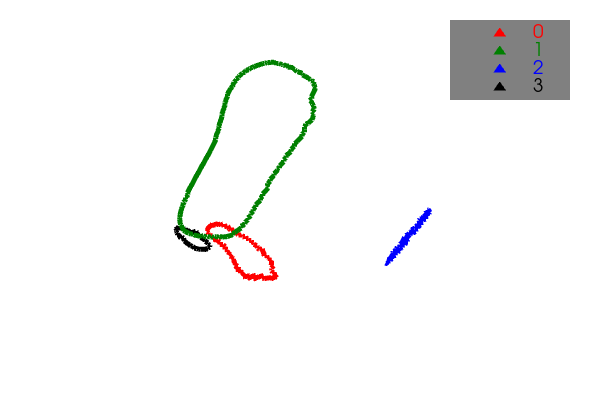

In [6]:
COLOURS = ['r','g','b','k','m','c','y']

P = draw_free_boundaries(FB,colour = COLOURS)
P.background_color = "white"
P.add_legend([['0',COLOURS[0]],['1',COLOURS[1]],['2',COLOURS[2]],['3',COLOURS[3]]])
P.show(jupyter_backend='static',window_size=[600,400])

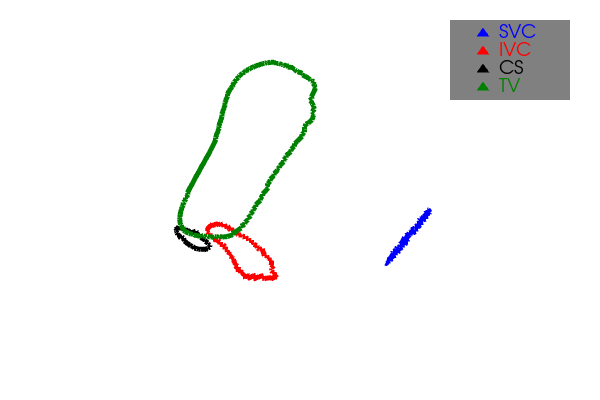

In [7]:
# Adjust the names for each boundary
boundaryNames = {'SVC':2,
                 'IVC':0,
                 'CS':3,
                 'TV':1}
P = draw_free_boundaries(FB,colour = COLOURS)
P.background_color = "white"
P.add_legend([[name,COLOURS[c]] for name,c in boundaryNames.items()])
P.show(jupyter_backend='static',window_size=[600,400])


In [8]:
ivcIndices = FF[boundaryNames['IVC']]#[:,0]
svcIndices = FF[boundaryNames['SVC']]#[:,0]
csIndices = FF[boundaryNames['CS']]#[:,0]
tvIndices = FF[boundaryNames['TV']]#[:,0]

## Selection of landmarks

The following landmarks have to be selected __IN ORDER__:

- IVC-RA Junction in the direction of IVC
- SVC-RA Junction in the direction of IVC
- SVC-RA Junction in the direction of TV
- TV ring in the direction of SVC
- TV ring in the direction of IVC
- IVC-RA Junction in the direction of TV

Use Paraview for this if using WSL and if you value your sanity

In [9]:
# pointIndices = []
# def callback(x,y,list = pointIndices): 
#     print(y)
#     return list.append(y)
    
# plotter = draw_map(mesh,np.zeros(mesh.n_cells),free_boundaries = False)
# plotter = draw_free_boundaries(FB,plotter=plotter,colour = COLOURS)
# plotter.enable_point_picking(pickable_window=False,
#                              left_clicking=False,
#                              use_mesh =True,
#                              callback = callback) 
# # # plotter.window_size = [400, 400]
# plotter.add_legend([[name,COLOURS[c]] for name,c in boundaryNames.items()])
# plotter.background_color = "white"
# plotter.show()

In [10]:
## This cell is for adjusting the indices, which may not always be easy to pick
# If pointIndices is correct:
# pointIndices = np.array(pointIndices)

# Otherwise, manual input
# # RA_1
# pointIndices = {'IVC-RA':22987,
#                 'SVC-RA':5360,
#                 'SVC-TV':32255,
#                 'TV-SVC':65162,
#                 'TV-IVC':8407,
#                 'IVC-TV':33390}

# # RA_2
# pointIndices = {'IVC-RA':1223,
#                 'SVC-RA':21715,
#                 'SVC-TV':20062,
#                 'TV-SVC':10633,
#                 'TV-IVC':52279,
#                 'IVC-TV':7214}
# Model Endo
# pointIndices = {'IVC-RA':1074,
#                 'SVC-RA':1299,
#                 'SVC-TV':1230,
#                 'TV-SVC':1402,
#                 'TV-IVC':1163,
#                 'IVC-TV':1172}

# # Model Epi
# pointIndices = {'IVC-RA':1292,
#                 'SVC-RA':1466,
#                 'SVC-TV':1450,
#                 'TV-SVC':1654,
#                 'TV-IVC':1117,
#                 'IVC-TV':1334}



# # ADAS 02
# pointIndices = {'IVC-RA':16107,
#                 'SVC-RA':31957,
#                 'SVC-TV':28752,
#                 'TV-SVC':109,
#                 'TV-IVC':10793,
#                 'IVC-TV':8138}

# ADAS 03
# pointIndices = {'IVC-RA':21228,
#                 'SVC-RA':728,
#                 'SVC-TV':31872,
#                 'TV-SVC':21794,
#                 'TV-IVC':32507,
#                 'IVC-TV':1336}
# ADAS 03B
pointIndices = {'IVC-RA':34890,
                'SVC-RA':21044,
                'SVC-TV':33395,
                'TV-SVC':21786,
                'TV-IVC':34071,
                'IVC-TV':475}

In [11]:
# Fix for possible missing points
if np.sum(removeInds)>0:
    for key,value in pointIndices.items():
        pointIndices[key] = np.where(ridx==value)[0][0]
pointIndices

{'IVC-RA': 34890,
 'SVC-RA': 21044,
 'SVC-TV': 33395,
 'TV-SVC': 21786,
 'TV-IVC': 34071,
 'IVC-TV': 475}

In [12]:
# Project TV points onto TV
# In the original, the TV point selection is done automatically

boundaryPoints = mesh.points[tvIndices,:]

dists = np.linalg.norm(boundaryPoints-mesh.points[pointIndices['TV-IVC'],:],axis=1)
pointIndices['TV-IVC'] = tvIndices[np.where(dists==np.nanmin(dists))[0][0]]

dists = np.linalg.norm(boundaryPoints-mesh.points[pointIndices['TV-SVC'],:],axis=1)
pointIndices['TV-SVC'] = tvIndices[np.where(dists==np.nanmin(dists))[0][0]]



## Create paths between the landmarks

The boundaries are:

- $\alpha_{RA}$ - Lateral-Septal coordinate:
    - Lower boundary = TV ring
    - Upper boundary = lateral-septal boundary + lateral compontent of IVC and SVC
- $\beta_{RA}$ - IVC-SVC coordinate:
    - Lower boundary = IVC-TV path
    - Upper boundary = SVC-TV path

In [13]:
# pointIndices = ringPointIndex

Paths = {'IVC-SVC':['IVC-RA','SVC-RA'],
         'SVC-A':['SVC-RA','SVC-TV'],
         'IVC-A':['IVC-TV','IVC-RA'],
         'SVC-TV':['SVC-TV','TV-SVC'],
         'IVC-TV':['IVC-TV','TV-IVC']}


for pathName,pathComponents in Paths.items():
    path = calculate_vertex_path(mesh,pointIndices[pathComponents[0]],pointIndices[pathComponents[1]])
    Paths[pathName] = path

# Paths['IVC-SVC'] = np.hstack([Paths['IVC'],Paths['IVC-SVC'],Paths['SVC']])

# P = pv.Plotter()

# for i,path in enumerate(Paths.values()):
#     P.add_lines(mesh.points[path],COLOURS[i])

# P.add_lines(mesh.points[tvIndices],'w')
# P.show(jupyter_backend='static')

In [14]:
# Define IVC and SVC junction rings: The rest of the vein is not the boundary

# IVC

# veinPoints = mesh.points[ivcIndices,:]
# V1 = mesh.points[pointIndices['IVC-RA']]-np.mean(veinPoints,axis=0)
# V2 = mesh.points[pointIndices['IVC-TV']]-np.mean(veinPoints,axis=0)
meanExtremes = np.mean(mesh.points[[pointIndices['IVC-RA'],pointIndices['IVC-TV']]],axis=0)

# n = np.cross(V2,V1)
n = mesh.points[Paths['IVC-A'][len(Paths['IVC-A'])//2]]-meanExtremes
n = n/np.linalg.norm(n)

clippedMesh = mesh.clip(n,origin =meanExtremes)


seed = clippedMesh.find_closest_point(mesh.points[pointIndices['IVC-TV']])
target = clippedMesh.find_closest_point(mesh.points[pointIndices['IVC-RA']])

pathA = calculate_vertex_path(clippedMesh,seed,target)
Paths['IVC-B'] = [mesh.find_closest_point(clippedMesh.points[ind]) for ind in pathA]

# #Fill gaps
pathA = calculate_vertex_path(mesh,pointIndices['IVC-TV'],Paths['IVC-B'][0])
pathB = calculate_vertex_path(mesh,Paths['IVC-B'][-1],pointIndices['IVC-RA'])

Paths['IVC-B'] = np.hstack([pathA,Paths['IVC-B'],pathB])

# SVC

# veinPoints = mesh.points[svcIndices,:]
# V1 = mesh.points[pointIndices['SVC-RA']]-np.mean(veinPoints,axis=0)
# V2 = mesh.points[pointIndices['SVC-TV']]-np.mean(veinPoints,axis=0)
meanExtremes = np.mean(mesh.points[[pointIndices['SVC-RA'],pointIndices['SVC-TV']]],axis=0)

# n = np.cross(V2,V1)
n = mesh.points[Paths['SVC-A'][len(Paths['SVC-A'])//2]]-meanExtremes
n = n/np.linalg.norm(n)

clippedMesh = mesh.clip(n,origin =meanExtremes)

seed = clippedMesh.find_closest_point(mesh.points[pointIndices['SVC-RA']])
target = clippedMesh.find_closest_point(mesh.points[pointIndices['SVC-TV']])

pathA = calculate_vertex_path(clippedMesh,seed,target)
Paths['SVC-B'] = [mesh.find_closest_point(clippedMesh.points[ind]) for ind in pathA]

#Fill gaps
pathA = calculate_vertex_path(mesh,pointIndices['SVC-RA'],Paths['SVC-B'][0])
pathB = calculate_vertex_path(mesh,Paths['SVC-B'][-1],pointIndices['SVC-TV'])

Paths['SVC-B'] = np.hstack([pathA,Paths['SVC-B'],pathB])


In [15]:
# Check to see if the boundaries are correct
P = pv.Plotter()

P.add_lines(mesh.points[Paths['IVC-A']],'r')
P.add_lines(mesh.points[Paths['IVC-B']],'orange')
P.add_lines(mesh.points[Paths['SVC-A']],'b')
P.add_lines(mesh.points[Paths['SVC-B']],'g')

P.add_mesh(mesh)
P.show()#jupyter_backend='static')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [16]:
#Set the upper boundary

ivcLateral = 'B'
ivcSeptal = 'A'

svcLateral = 'B'
svcSeptal = 'A'

Paths['latero-septal-border'] = np.hstack([Paths['IVC-'+ivcLateral],Paths['IVC-SVC'],Paths['SVC-'+svcLateral]])

uniqueVals,indices = np.unique(Paths['latero-septal-border'],return_index=1)
Paths['latero-septal-border'] = uniqueVals[np.argsort(indices)]


## Prepare files for openCARP

The laplacian solution is done in openCARP. This next section deals with preparing parameter files for the solver

In [17]:
# splittedMeshes = newMesh.connectivity(largest=False)
carpFolder = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC_py/carp/'

In [18]:
## Make .elem file
try:
    data = mesh.get_array('RegionId')
except:
    data = np.zeros(mesh.n_cells,int)


with open(os.path.join(carpFolder,'%s.elem'%expName),'w') as file:
    file.write('%d\n'%mesh.n_cells)
    for trInd in range(mesh.n_cells):
        triangle = mesh.cell_point_ids(trInd)
        if trInd!=mesh.n_cells-1:
            file.write('Tr %d %d %d %d\n'%(triangle[0],triangle[1],triangle[2],data[trInd]))
        else:
            file.write('Tr %d %d %d %d'%(triangle[0],triangle[1],triangle[2],data[trInd]))


In [19]:
## Make .pts file
with open(os.path.join(carpFolder,'%s.pts'%expName),'w') as file:
    file.write('%d\n'%mesh.n_points)
    for i,point in enumerate(mesh.points):
        if i!=mesh.n_points-1:
            file.write('%f %f %f\n'%(point[0],point[1],point[2]))
        else:
            file.write('%f %f %f'%(point[0],point[1],point[2]))

In [20]:
## Make .lon file
with open(os.path.join(carpFolder,'%s.lon'%expName),'w') as file:
    file.write('1\n')
    for trInd in range(mesh.n_cells):
        if trInd!=mesh.n_cells-1:
            file.write('%f %f %f\n'%(1,0,0))
        else:
            file.write('%f %f %f'%(1,0,0))
        

In [21]:
# Write TV file
with open(os.path.join(carpFolder,'TCV.vtx'),'w') as file:
    file.write('%d'%len(tvIndices))
    file.write('\n%s'%'extra')
    for tvIndex in tvIndices:
        file.write('\n%d'%tvIndex)

# Write ICV_SCV file
with open(os.path.join(carpFolder,'ICV_SCV.vtx'),'w') as file:
    file.write('%d'%len(Paths['latero-septal-border']))
    file.write('\n%s'%'extra')
    for pathIndex in Paths['latero-septal-border']:
        file.write('\n%d'%pathIndex)

# Write IVC-TV file
with open(os.path.join(carpFolder,'ICV_TV.vtx'),'w') as file:
    # file.write('%d'%len(ivcIndices))
    file.write('%d'%(len(Paths['IVC-TV'])))
    # TEST
    # file.write('\n%s'%'extra')
    # for ivcIndex in ivcIndices:
    #     file.write('\n%d'%ivcIndex)
    
    for ivcIndex in Paths['IVC-TV']:
        file.write('\n%d'%ivcIndex)

# Write SVC file
with open(os.path.join(carpFolder,'SCV_TV.vtx'),'w') as file:
    # file.write('%d'%len(svcIndices))
    file.write('%d'%(len(Paths['SVC-TV'])))
    file.write('\n%s'%'extra')
    # TEST
    # for svcIndex in svcIndices:
    #     file.write('\n%d'%svcIndex)
    
    for svcIndex in Paths['SVC-TV']:
        file.write('\n%d'%svcIndex)

In [22]:
referenceParFolder = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC'

## Solution for Alpha coordinates
parFile = open(os.path.join(referenceParFolder,'sample_1.par'),'r')
parFile = parFile.readlines()

parFile[0] = 'meshname = %s\n'%expName

with open(os.path.join(carpFolder,'%s_Alpha.par'%expName),'w') as file:
    for row in parFile: file.write('%s'%row)

## Solution for Beta Coordinates
parFile = open(os.path.join(referenceParFolder,'sample_2.par'),'r')
parFile = parFile.readlines()

parFile[0] = 'meshname = %s\n'%expName
parFile[27] = 'stimulus[0].vtx_file = ICV_TV\n'
parFile[32] = 'stimulus[1].vtx_file = SCV_TV\n'

with open(os.path.join(carpFolder,'%s_Beta.par'%expName),'w') as file:
    for row in parFile: file.write('%s'%row)


## Solve the Laplacian in openCARP

In [23]:
os.chdir(carpFolder)
os.system('openCARP +F %s_Alpha.par'%expName)

os.chdir('OUTPUT_DIR')
os.rename('phie.igb','%s_alpha.igb'%expName)
os.rename('phie_i.igb','%s_i_alpha.igb'%expName)
os.chdir('..')

L4 : Warning: No physics region defined! Please set phys_region parameters to correctly define physics.
L4 : IntraElec and ExtraElec domains will be derived from fibers.

L1 : Warning: Legacy stimuli defined. Please consider switching to stimulus definition "stim[]"!



    *** Processing meshes ***

Reading reference mesh: ADAS03B_RA.*
Done in 0.345742 sec.
Done in 0.000306 sec.
Processing submeshes
All done in 0.464536 sec.

    *** Initializing physics ***

Initializing Laplace solver ..
Setting up extracellular tissue poperties for 1 regions ..
Setting up intracellular tissue poperties for 1 regions ..
Stimulus 0: Selecting vertices from file TCV.vtx
Stimulus 1: Selecting vertices from file ICV_SCV.vtx
Computed ellipitc stiffness matrix in 0.058 seconds.
Elliptic lhs matrix enforcing Dirichlet boundaries.
Elliptic lhs matrix Dirichlet enforcing done in 0.005 seconds.
Solving elliptic PDE (PETSc) system using absolute tolerance (1e-08) of preconditioned residual
as stopping criterion
elliptic PDE (PETSc) solver: switching to default settings "-ksp_type cg -pc_type hypre -pc_hypre_type boomeramg -pc_hypre_boomeramg_max_iter 1 -pc_hypre_boomeramg_strong_threshold 0.0 -options_left".
Initializing elliptic solver in 0.00935 seconds.

    *** Launching

Adjusting dim_t to make dimensions consistent
Adjusting dim_t to make dimensions consistent


PROG	----- 	----	-------	-------|
time	%%comp	time	 ctime 	  ETA  |
0.00	0.0	0.0	0:00:00	0:00:00
Solving Laplace problem ..
Done in 0.39131 seconds.


Timings of individual physics:
------------------------------

Laplace solver:
  Init:    0.16 sec
  Compute: 0.39 sec
  Output:  0.00 sec


    *** Destroying physics ***

Destroying Laplace solver ..


In [24]:
os.system('openCARP +F %s_Beta.par'%expName)

os.chdir('OUTPUT_DIR')
os.rename('phie.igb','%s_beta.igb'%expName)
os.rename('phie_i.igb','%s_i_beta.igb'%expName)
os.chdir('..')

L4 : Warning: No physics region defined! Please set phys_region parameters to correctly define physics.
L4 : IntraElec and ExtraElec domains will be derived from fibers.

L1 : Warning: Legacy stimuli defined. Please consider switching to stimulus definition "stim[]"!



    *** Processing meshes ***

Reading reference mesh: ADAS03B_RA.*
Done in 0.379348 sec.
Done in 0.000408 sec.
Processing submeshes
All done in 0.498410 sec.

    *** Initializing physics ***

Initializing Laplace solver ..
Setting up extracellular tissue poperties for 1 regions ..
Setting up intracellular tissue poperties for 1 regions ..
Stimulus 0: Selecting vertices from file ICV_TV.vtx
Stimulus 1: Selecting vertices from file SCV_TV.vtx


L3 : warn_when_passing_intra_vtx warning: Could not derive grid type info from file ICV_TV.vtx
Adjusting dim_t to make dimensions consistent
Adjusting dim_t to make dimensions consistent


Computed ellipitc stiffness matrix in 0.061 seconds.
Elliptic lhs matrix enforcing Dirichlet boundaries.
Elliptic lhs matrix Dirichlet enforcing done in 0.003 seconds.
Solving elliptic PDE (PETSc) system using absolute tolerance (1e-08) of preconditioned residual
as stopping criterion
elliptic PDE (PETSc) solver: switching to default settings "-ksp_type cg -pc_type hypre -pc_hypre_type boomeramg -pc_hypre_boomeramg_max_iter 1 -pc_hypre_boomeramg_strong_threshold 0.0 -options_left".
Initializing elliptic solver in 0.00133 seconds.

    *** Launching simulation ***

PROG	----- 	----	-------	-------|
time	%%comp	time	 ctime 	  ETA  |
0.00	0.0	0.0	0:00:00	0:00:00
Solving Laplace problem ..
Done in 0.31161 seconds.


Timings of individual physics:
------------------------------

Laplace solver:
  Init:    0.14 sec
  Compute: 0.31 sec
  Output:  0.00 sec


    *** Destroying physics ***

Destroying Laplace solver ..


## Split the mesh for correcting the coordinates

The mesh has to be split into lateral and septal regions by a boundary composed of the following paths:
- TV-IVC
- IVC seeds
- IVC-SVC
- SVC seeds
- SVC-TV

In [25]:
# dists_ivc_ra = np.linalg.norm(mesh.points[ivcIndices]-mesh.points[pointIndices['IVC-RA']],axis=1)
# ivc_ra = ivcIndices[np.where(dists_ivc_ra==np.min(dists_ivc_ra))[0][0]]

# dists_ivc_tv = np.linalg.norm(mesh.points[ivcIndices]-mesh.points[pointIndices['IVC-TV']],axis=1)
# ivc_tv = ivcIndices[np.where(dists_ivc_tv==np.min(dists_ivc_tv))[0][0]]

# dists_svc_ra = np.linalg.norm(mesh.points[svcIndices]-mesh.points[pointIndices['SVC-RA']],axis=1)
# svc_ra = svcIndices[np.where(dists_svc_ra==np.min(dists_svc_ra))[0][0]]

# dists_svc_tv = np.linalg.norm(mesh.points[svcIndices]-mesh.points[pointIndices['SVC-TV']],axis=1)
# svc_tv = svcIndices[np.where(dists_svc_tv==np.min(dists_svc_tv))[0][0]]

# tv_ivcPath = calculate_vertex_path(mesh,pointIndices['TV-IVC'],ivc_tv)
# ivcPath = calculate_vertex_path(mesh,ivc_tv,ivc_ra)
# ivc_svcPath = calculate_vertex_path(mesh,ivc_ra,svc_ra)
# svcPath = calculate_vertex_path(mesh,svc_ra,svc_tv)
# svc_tvPath = calculate_vertex_path(mesh,svc_tv,pointIndices['TV-SVC'])


lateroSeptalBoundary = np.hstack([Paths['IVC-TV'],Paths['latero-septal-border'],Paths['SVC-TV']])



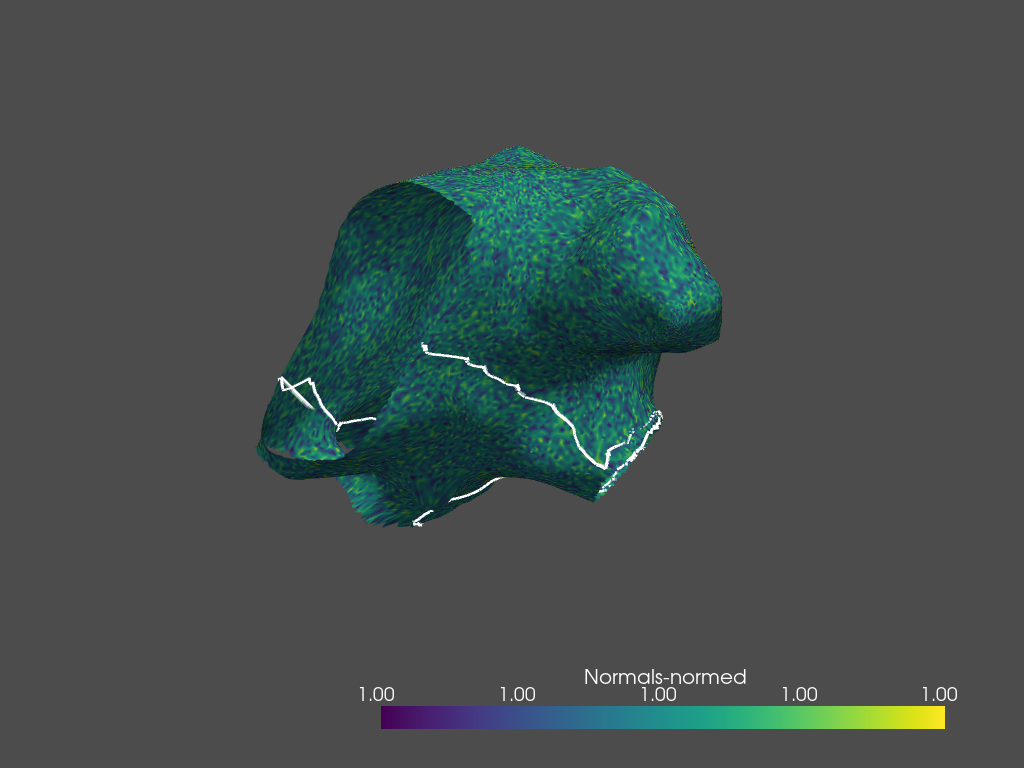

In [26]:
# Check if path is correct, may need to invert a few paths
P = pv.Plotter()
P.add_mesh(mesh)
P.add_lines(mesh.points[lateroSeptalBoundary])
# P.add_lines(mesh.points[svcPath])
P.show(jupyter_backend='static')
    

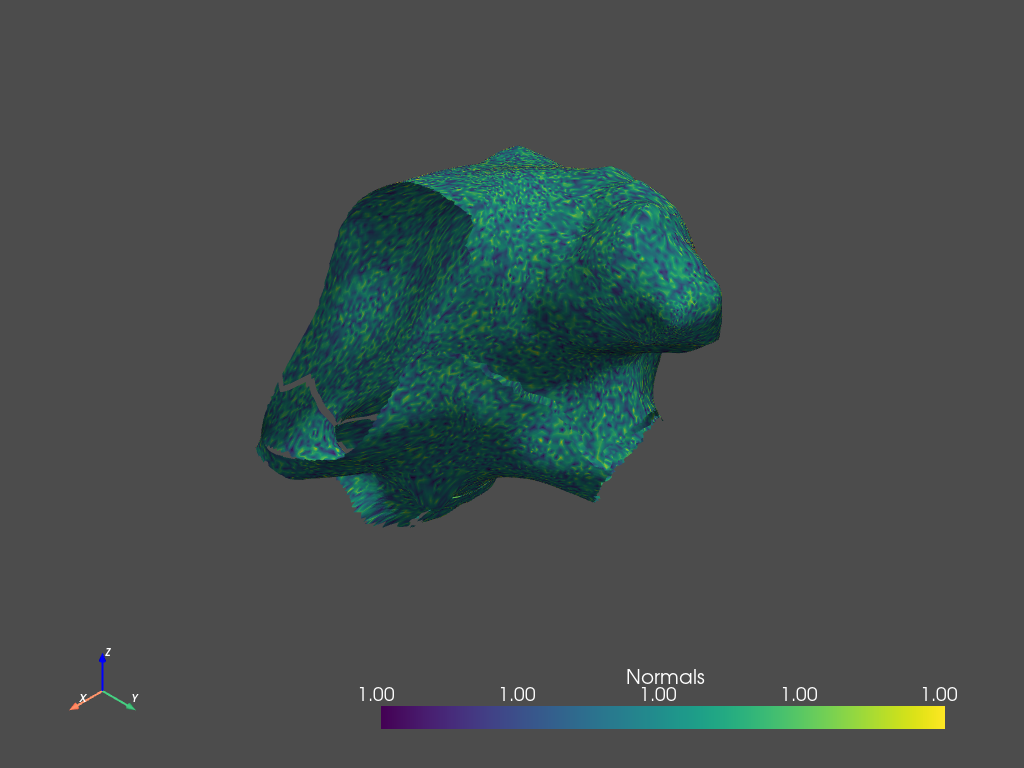

In [27]:
newMesh = deepcopy(mesh)
newMesh,_ = newMesh.remove_points(lateroSeptalBoundary)
newMesh.plot(jupyter_backend='static')

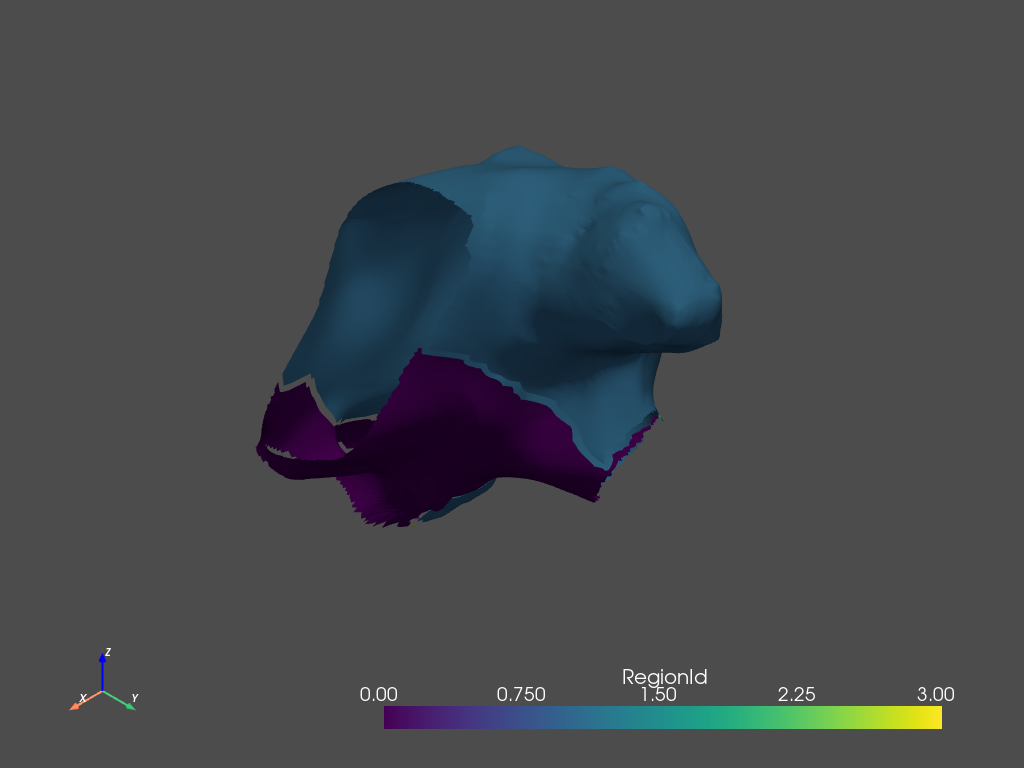

In [28]:
# Split mesh
slicedMesh = newMesh.connectivity(largest=False)
slicedMesh.plot(jupyter_backend='static')

In [29]:
# Get rearranged indexes because the connected mesh messes this up
rearrangeInds = np.ones(slicedMesh.n_points,int)
A = slicedMesh.points
B = mesh.points

for i in range(slicedMesh.n_points):

    ind = np.where((A[i,0]==B[:,0])*(A[i,1]==B[:,1])*(A[i,2]==B[:,2]))[0][0]
    rearrangeInds[i] = ind

In [30]:
#Get Region Ids
slicedRegions = slicedMesh.point_data.get_array('RegionId')
slicedRegions[slicedRegions>1] = 1

# Put them in a pointData array, rearranged
pointData = np.ones(mesh.n_points)*-1
pointData[rearrangeInds] = slicedRegions

# Interpolate missing points
undefinedPoints = np.where(~np.isin(pointData,[0,1]))[0] # 0 and 1 should ideally be the only labels
definedPoints = np.where(np.isin(pointData,[0,1]))[0]

definedMatrix = mesh.points[definedPoints]

newValues = np.zeros(len(undefinedPoints))
for i,point in enumerate(undefinedPoints):
    point = mesh.points[point]
    dists = np.linalg.norm(definedMatrix-point,axis=1)
    closestInd = np.where(dists==np.min(dists))[0][0]
    newValues[i] = pointData[definedPoints[closestInd]]

pointData[undefinedPoints] = newValues



In [31]:
# Add data to mesh
mesh.point_data['RegionId'] = pointData
mesh.plot(scalars='RegionId')#,jupyter_backend='static')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Correct coordinates

In this step, it is necessary to mark which portion of the sliced mesh (septal or lateral) is 0 and 1. Then, the new coordinates are calculated as:

- Laterally: $\alpha_{RA} = 0.5 \cdot \psi$
- Septally: $\alpha_{RA} = 1-0.5 \cdot \psi$

For the Laplacian solution $\psi$

In [32]:
# Input the code of the septal and lateral wall based on the image above

SeptalCode = int(np.unique(mesh.point_data['RegionId'][csIndices])[0])
LateralCode = 1-SeptalCode
print(SeptalCode)

0


In [33]:
## Load Igbs
alphaFile = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC_py/carp/OUTPUT_DIR/%s_alpha.igb'%expName
betaFile = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC_py/carp/OUTPUT_DIR/%s_beta.igb'%expName

alpha,hdr_a = igb.Load(alphaFile)
beta,hdr_b = igb.Load(betaFile)

mesh.point_data['alpha'] = alpha
mesh.point_data['beta'] = beta

In [34]:
################## Beta Adjustment

## Get only lateral wall
meshLateral = deepcopy(mesh)
toRemove = meshLateral.point_data['RegionId']==SeptalCode
toRemove[lateroSeptalBoundary] = False
meshLateral,ridx = meshLateral.remove_points(toRemove)

## Select points with beta == 0 to beta == 1
# we get the "mid point" of the region with the extreme beta values

indA = np.where(meshLateral.point_data['beta']==0)[0]
indA = indA[np.argsort(meshLateral.point_data['alpha'][indA])]
indA = indA[len(indA)//2]

indB = np.where(meshLateral.point_data['beta']==1)[0]
indB = indB[np.argsort(meshLateral.point_data['alpha'][indB])]
indB = indB[len(indB)//2]

## Get the part of the mesh only with similar alpha
aA = meshLateral.point_data['alpha'][indA]
aB = meshLateral.point_data['alpha'][indB]

tol = .2# I don't get why this makes a difference but ok
toRemove = (meshLateral.point_data['alpha']<np.min([aA,aB])-tol) ^ (meshLateral.point_data['alpha']>np.max([aA,aB])+tol) 
meshLateral,ridx2 = meshLateral.remove_points(toRemove,mode='any')

indA = np.where(ridx2==indA)[0][0]
indB = np.where(ridx2==indB)[0][0]

## Find the shortest path between the points with beta ==0 and beta ==1
# And get the beta progression
path = calculate_vertex_path(meshLateral,indA,indB)
betaPath = meshLateral.point_data['beta'][path]

## Calculate the equivalent normalized geodesic distance
pathDistance = [calculate_vertex_distance(meshLateral,indA,index) for index in path[1:]]
pathDistance = np.hstack([0,pathDistance])
pathDistance = (pathDistance-pathDistance.min())/(pathDistance.max()-pathDistance.min()) # normalize

## Now map the remaining beta values based on the relationship between betaPath and pathDistance
rescaledBeta = np.zeros_like(beta)*np.nan
for index,b in enumerate(mesh.point_data['beta']):
    if b==0 or b==1:
        rescaledBeta[index] = b
        continue

    betaLims = np.array([np.max(betaPath[betaPath<b]),np.min(betaPath[betaPath>b])])

    neighborInds = [np.where(betaPath==[betaLims[0]])[0][-1],np.where(betaPath==[betaLims[1]])[0][0]]
    distLims = pathDistance[neighborInds]

    # # find neighbors
    # dists = np.abs(betaPath-b)

    # # "x"
    # betaLims = betaPath[np.argsort(dists)[:3]]
    # # "y"
    # distLims = pathDistance[np.argsort(dists)[:3]]

    #Linear interpolation
    rescaledBeta[index] = (distLims.max()-distLims.min())*(b-betaLims.min())/(betaLims.max()-betaLims.min())+distLims.min()

## Update beta values
mesh.point_data['beta'] = rescaledBeta

In [35]:
b

0.78936446

Text(0.5, 0.98, 'Visualization of how much the beta was rescaled')

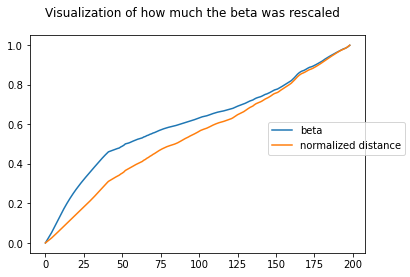

In [36]:
fig,ax = plt.subplots(1)
ax.plot(betaPath,label='beta')
ax.plot(pathDistance,label='normalized distance')
fig.legend(loc=5)
fig.suptitle('Visualization of how much the beta was rescaled')

In [37]:
################## Alpha Adjustment

alpha[pointData==LateralCode] = 0.5*alpha[pointData==LateralCode]
alpha[pointData==SeptalCode] = 1-0.5*alpha[pointData==SeptalCode]
mesh.point_data['alpha'] = alpha

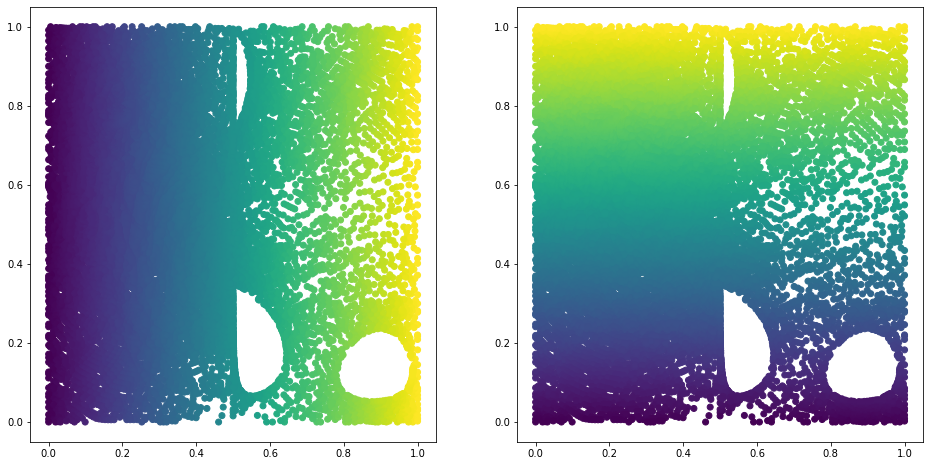

In [38]:
downsample=2

fig,ax = plt.subplots(1,2,figsize = (16,8))
cax = ax[0].scatter(mesh.point_data['alpha'][::downsample],mesh.point_data['beta'][::downsample],c=mesh.point_data['alpha'][::downsample])
ax[1].scatter(mesh.point_data['alpha'][::downsample],mesh.point_data['beta'][::downsample],c=mesh.point_data['beta'][::downsample])
# plt.colorbar(cax)

In [39]:
# Write igb
# I cheat here because my function is not working
os.chdir(carpFolder)

file = open(alphaFile,'rb')
hdr_a = file.read(1024)
file.close()

outFile = open('%s_alpha_corrected.igb'%expName,'wb')
outFile.write(hdr_a)
outFile.close()

outFile = open('%s_alpha_corrected.igb'%expName,'ab')
mesh.point_data['alpha'].tofile(outFile)

# Beta
file = open(betaFile,'rb')
hdr_b = file.read(1024)
file.close()

outFile = open('%s_beta_corrected.igb'%expName,'wb')
outFile.write(hdr_b)
outFile.close()

outFile = open('%s_beta_corrected.igb'%expName,'ab')
mesh.point_data['beta'].tofile(outFile)

In [40]:
# Save VTK
mesh.save('%s.vtk'%expName)
mesh.save('%s.ply'%expName)


## Missing steps

Apparently there is an additional step in which a _"Coordinate Rescaling"_ is performed. I did not get that and need to ask Ali.

<span style="color:yellow">UPDATE: I have implemented this step based on what I understood from the other papers mentioned by Roney et al. May be wrong but I think it makes sense. The definition of the path is possibly something that needs to be worked out</span>.

In the igbs from the Atlas, it seems that the lower and upper boundaries are actually the vein rings + lines connecting them to the TV. I think I can try that out


